<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Report-Without-Ground-Truth-v1.0" data-toc-modified-id="Report-Without-Ground-Truth-v1.0-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Report Without Ground Truth v1.0</a></span><ul class="toc-item"><li><span><a href="#Input-prameters" data-toc-modified-id="Input-prameters-1.1"><span class="toc-item-num">1.1&nbsp;&nbsp;</span>Input prameters</a></span></li></ul></li><li><span><a href="#Variants-Statistics" data-toc-modified-id="Variants-Statistics-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Variants Statistics</a></span></li><li><span><a href="#Snp-statistics" data-toc-modified-id="Snp-statistics-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Snp statistics</a></span><ul class="toc-item"><li><span><a href="#Trinucleotide-Heatmap" data-toc-modified-id="Trinucleotide-Heatmap-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Trinucleotide Heatmap</a></span></li></ul></li><li><span><a href="#INDEL-statistics" data-toc-modified-id="INDEL-statistics-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>INDEL statistics</a></span><ul class="toc-item"><li><span><a href="#Distribution-of-indel-lengths" data-toc-modified-id="Distribution-of-indel-lengths-4.1"><span class="toc-item-num">4.1&nbsp;&nbsp;</span>Distribution of indel lengths</a></span></li><li><span><a href="#Insertion-Deletion-Statistics-for-h-mer-indels" data-toc-modified-id="Insertion-Deletion-Statistics-for-h-mer-indels-4.2"><span class="toc-item-num">4.2&nbsp;&nbsp;</span>Insertion Deletion Statistics for h-mer indels</a></span></li></ul></li></ul></div>

# Report Without Ground Truth v1.0
## Input prameters

In [49]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
from configparser import ConfigParser
import warnings
warnings.filterwarnings('ignore')


pd.options.display.float_format = lambda x: '{:,.1e}'.format(x) if x>1e6 else '{:,.1f}'.format(x)
pd.options.display.max_colwidth = 100

configFile='no_gt_report.config'
parser = ConfigParser()
parser.read(configFile)

no_gt_statistics_unfiltered= parser.get('NOGTReport', 'h5_statistics', fallback='no_gt_statistics_unfiltered.h5')
no_gt_statistics_filtered = parser.get('NOGTReport', 'filtered_h5_statistics', fallback='no_gt_statistics_filtered.h5')
no_gt_statistics_unfiltered_wgs = parser.get('NOGTReport', 'h5_statistics_wgs', fallback='no_gt_statistics_unfiltered_wgs.h5')
no_gt_statistics_filtered_wgs = parser.get('NOGTReport', 'filtered_h5_statistics_wgs', fallback='no_gt_statistics_filtered_wgs.h5')

is_somatic = parser.getboolean('NOGTReport', 'is_somatic', fallback=False)
filtered_vcf = parser.get('NOGTReport', 'filtered_vcf',fallback='filtered_vcf.vcf.gz')
annotation_intervals_names=parser.get('NOGTReport', 'annotation_intervals_names',fallback='annotation_intervals_names').split(',')
interval_list = parser.get('NOGTReport', 'interval_list')
ref_fasta = parser.get('NOGTReport', 'ref_fasta',fallback='Homo_sapiens_assembly38.fasta')
ref_fasta_dict = parser.get('NOGTReport', 'ref_fasta_dict', fallback='Homo_sapiens_assembly38.dict')

prmNames=['run_id','pipeline_version',
          'h5_statistics', 'filtered_h5_statistics',
          'h5_statistics_wgs', 'filtered_h5_statistics_wgs','annotation_intervals_names','is_somatic','filtered_vcf',
          'interval_list'
         ]

prm={}
for name in prmNames:
    prm[name]=parser.get('NOGTReport', name)
    
h5outfile = parser.get('NOGTReport', 'h5_output', fallback='no_gt_report.h5')

prmdf = pd.DataFrame.from_dict(prm, orient='index',columns=['value']).reindex(prmNames)
prmdf.to_hdf(h5outfile, key="parameters")
prmdf

,value
run_id,infer_HG001_015863_UGAv3_209_v1.1.1
pipeline_version,1.4.0
h5_statistics,/data/deepvariants/infer_HG001_015863_UGAv3_209_v1.1.1.unfilt.no_gt_stats.h5
filtered_h5_statistics,
h5_statistics_wgs,/data/deepvariants/infer_HG001_015863_UGAv3_209_v1.1.1.unfilt.no_gt_stats_wgs.h5
filtered_h5_statistics_wgs,
annotation_intervals_names,"EXOME,LCR,MAP_UNIQUE,LONG_HMER,UG_HCR"
is_somatic,false
filtered_vcf,/data/deepvariants/infer_HG001_015863_UGAv3_209_v1.1.1.ann.vcf.gz
interval_list,data/deepvariants/chr20_calling_regions.hg38.interval_list


In [50]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from os.path import join as pjoin
from matplotlib.lines import Line2D

from ugvc.dna.utils import revcomp
import ugvc.vcfbed.vcftools as vcftools
import ugvc.comparison.vcf_pipeline_utils as vcf_pipeline_utils

In [51]:
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 26
TITLE_SIZE = 36
FIGSIZE = (16, 8)
GRID = True
COLORS = [
    "blue",
    "red",
    "green",
    "magenta",
    "black",
    "brown",
    "orange",
    "salmon",
    "teal",
    "coral",
    "lime",
    "purple",
    "cyan",
    "lavender",
    "turquoise",
    "darkgreen",
    "tan",
    "lightblue",
    "pink",
    "yellow",
    "gold",
]

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=TITLE_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc("axes", grid=GRID)  # is grid on
plt.rc("axes", prop_cycle=plt.cycler(color=COLORS))
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc("figure", titlesize=TITLE_SIZE)  # fontsize of the figure title
plt.rc("figure", figsize=FIGSIZE)  # size of the figure

# Variants Statistics

In [52]:
import pandas as pd
def metric_table_annotation(h5_path, annotation_name='none'):

    JexlExpression = annotation_name
    metric_table = pd.DataFrame(index=['nEvalVariants','nDeletions','nInsertions','nSNPs','nTi','nTv','tiTvRatio',
                                       'SNP_to_indel_ratio','indel_novelty_rate','insertion_to_deletion_ratio',
                                       'nHets','nHomVar','nMultiSNPs','nMultiIndels','nBiallelicSNPs','nBiallelicIndels'],
                                columns=['novel','known','all'])
    # CompOverlap
    CompOverlap = pd.read_hdf(h5_path,'eval_CompOverlap')
    CompOverlap[['nEvalVariants']] = CompOverlap[['nEvalVariants']].apply(lambda x : pd.to_numeric(x,errors='coerce'))
    metric_table.loc['nEvalVariants','known']=int(CompOverlap.loc[(CompOverlap['JexlExpression']==JexlExpression) & (CompOverlap['Novelty']=='known'),'nEvalVariants'].values[0])
    metric_table.loc['nEvalVariants','novel']=int(CompOverlap.loc[(CompOverlap['JexlExpression']==JexlExpression) & (CompOverlap['Novelty']=='novel'),'nEvalVariants'].values[0])
    metric_table.loc['nEvalVariants','all']=int(CompOverlap.loc[(CompOverlap['JexlExpression']==JexlExpression) & (CompOverlap['Novelty']=='all'),'nEvalVariants'].values[0])
    # CountVariants
    CountVariants = pd.read_hdf(h5_path,'eval_CountVariants')
    CountVariants[["nDeletions","nInsertions","nSNPs","nHets","nHomVar"]] = CountVariants[["nDeletions","nInsertions","nSNPs","nHets","nHomVar"]
                                                                       ].apply(lambda x : pd.to_numeric(x,errors='coerce'))
    metric_table.loc['nDeletions','known']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='known'),'nDeletions'].values[0])
    metric_table.loc['nDeletions','novel']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='novel'),'nDeletions'].values[0])
    metric_table.loc['nDeletions','all']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='all'),'nDeletions'].values[0])
    metric_table.loc['nInsertions','known']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='known'),'nInsertions'].values[0])
    metric_table.loc['nInsertions','novel']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='novel'),'nInsertions'].values[0])
    metric_table.loc['nInsertions','all']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='all'),'nInsertions'].values[0])
    metric_table.loc['nSNPs','known']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='known'),'nSNPs'].values[0])
    metric_table.loc['nSNPs','novel']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='novel'),'nSNPs'].values[0])
    metric_table.loc['nSNPs','all']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='all'),'nSNPs'].values[0])
    metric_table.loc['nHets','known']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='known'),'nHets'].values[0])
    metric_table.loc['nHets','novel']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='novel'),'nHets'].values[0])
    metric_table.loc['nHets','all']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='all'),'nHets'].values[0])
    metric_table.loc['nHomVar','known']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='known'),'nHomVar'].values[0])
    metric_table.loc['nHomVar','novel']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='novel'),'nHomVar'].values[0])
    metric_table.loc['nHomVar','all']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='all'),'nHomVar'].values[0])
    
    # MultiallelicSummary
    MultiallelicSummary = pd.read_hdf(h5_path,'eval_MultiallelicSummary')
    MultiallelicSummary[["nMultiSNPs","nMultiIndels","nSNPs","nIndels"]] = MultiallelicSummary[["nMultiSNPs","nMultiIndels","nSNPs","nIndels"]
                                                                       ].apply(lambda x : pd.to_numeric(x,errors='coerce'))
    metric_table.loc['nMultiSNPs','known']=int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='known'),'nMultiSNPs'].values[0])
    metric_table.loc['nMultiSNPs','novel']=int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='novel'),'nMultiSNPs'].values[0])
    metric_table.loc['nMultiSNPs','all']=int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='all'),'nMultiSNPs'].values[0])
    metric_table.loc['nMultiIndels','known']=int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='known'),'nMultiIndels'].values[0])
    metric_table.loc['nMultiIndels','novel']=int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='novel'),'nMultiIndels'].values[0])
    metric_table.loc['nMultiIndels','all']=int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='all'),'nMultiIndels'].values[0])
    metric_table.loc['nBiallelicSNPs','known']=int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='known'),'nSNPs'].values[0])- \
        int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='known'),'nMultiSNPs'].values[0])
    metric_table.loc['nBiallelicSNPs','novel']=int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='novel'),'nSNPs'].values[0])- \
        int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='novel'),'nMultiSNPs'].values[0])
    metric_table.loc['nBiallelicSNPs','all']=int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='all'),'nSNPs'].values[0]) - \
        int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='all'),'nMultiSNPs'].values[0])
    metric_table.loc['nBiallelicIndels','known']=int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='known'),'nIndels'].values[0]) - \
        int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='known'),'nMultiIndels'].values[0])
    metric_table.loc['nBiallelicIndels','novel']=int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='novel'),'nIndels'].values[0]) - \
        int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='novel'),'nMultiIndels'].values[0])
    metric_table.loc['nBiallelicIndels','all']=int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='all'),'nIndels'].values[0]) - \
        int(MultiallelicSummary.loc[(MultiallelicSummary['JexlExpression']==JexlExpression) & (MultiallelicSummary['Novelty']=='all'),'nMultiIndels'].values[0])

    # TiTvVariantEvaluator
    TiTvVariantEvaluator = pd.read_hdf(h5_path,'eval_TiTvVariantEvaluator')
    TiTvVariantEvaluator[["nTi","nTv","tiTvRatio"]] = TiTvVariantEvaluator[["nTi","nTv","tiTvRatio"]
                                                                       ].apply(lambda x : pd.to_numeric(x,errors='coerce'))
    metric_table.loc['nTi','known']=int(TiTvVariantEvaluator.loc[(TiTvVariantEvaluator['JexlExpression']==JexlExpression) & (TiTvVariantEvaluator['Novelty']=='known'),'nTi'].values[0])
    metric_table.loc['nTi','novel']=int(TiTvVariantEvaluator.loc[(TiTvVariantEvaluator['JexlExpression']==JexlExpression) & (TiTvVariantEvaluator['Novelty']=='novel'),'nTi'].values[0])
    metric_table.loc['nTi','all']=int(TiTvVariantEvaluator.loc[(TiTvVariantEvaluator['JexlExpression']==JexlExpression) & (TiTvVariantEvaluator['Novelty']=='all'),'nTi'].values[0])
    metric_table.loc['nTv','known']=int(TiTvVariantEvaluator.loc[(TiTvVariantEvaluator['JexlExpression']==JexlExpression) & (TiTvVariantEvaluator['Novelty']=='known'),'nTv'].values[0])
    metric_table.loc['nTv','novel']=int(TiTvVariantEvaluator.loc[(TiTvVariantEvaluator['JexlExpression']==JexlExpression) & (TiTvVariantEvaluator['Novelty']=='novel'),'nTv'].values[0])
    metric_table.loc['nTv','all']=int(TiTvVariantEvaluator.loc[(TiTvVariantEvaluator['JexlExpression']==JexlExpression) & (TiTvVariantEvaluator['Novelty']=='all'),'nTv'].values[0])
    metric_table.loc['tiTvRatio','known']=float(TiTvVariantEvaluator.loc[(TiTvVariantEvaluator['JexlExpression']==JexlExpression) & (TiTvVariantEvaluator['Novelty']=='known'),'tiTvRatio'].values[0])
    metric_table.loc['tiTvRatio','novel']=float(TiTvVariantEvaluator.loc[(TiTvVariantEvaluator['JexlExpression']==JexlExpression) & (TiTvVariantEvaluator['Novelty']=='novel'),'tiTvRatio'].values[0])
    metric_table.loc['tiTvRatio','all']=float(TiTvVariantEvaluator.loc[(TiTvVariantEvaluator['JexlExpression']==JexlExpression) & (TiTvVariantEvaluator['Novelty']=='all'),'tiTvRatio'].values[0])

    IndelSummary = pd.read_hdf(h5_path,'eval_IndelSummary')
    IndelSummary[["SNP_het_to_hom_ratio",
                       "SNP_to_indel_ratio",
                       "indel_het_to_hom_ratio",
                       "indel_novelty_rate",
                       "insertion_to_deletion_ratio"]] = IndelSummary[["SNP_het_to_hom_ratio",
                       "SNP_to_indel_ratio",
                       "indel_het_to_hom_ratio",
                       "indel_novelty_rate",
                       "insertion_to_deletion_ratio"]].apply(lambda x : pd.to_numeric(x,errors='coerce'))
    
    metric_table.loc['SNP_to_indel_ratio','known']=float(IndelSummary.loc[(IndelSummary['JexlExpression']==JexlExpression) & (IndelSummary['Novelty']=='known'),'SNP_to_indel_ratio'].values[0])
    metric_table.loc['SNP_to_indel_ratio','novel']=float(IndelSummary.loc[(IndelSummary['JexlExpression']==JexlExpression) & (IndelSummary['Novelty']=='novel'),'SNP_to_indel_ratio'].values[0])
    metric_table.loc['SNP_to_indel_ratio','all']=float(IndelSummary.loc[(IndelSummary['JexlExpression']==JexlExpression) & (IndelSummary['Novelty']=='all'),'SNP_to_indel_ratio'].values[0])
    metric_table.loc['indel_novelty_rate','known']=float(IndelSummary.loc[(IndelSummary['JexlExpression']==JexlExpression) & (IndelSummary['Novelty']=='known'),'indel_novelty_rate'].values[0])
    metric_table.loc['indel_novelty_rate','novel']=float(IndelSummary.loc[(IndelSummary['JexlExpression']==JexlExpression) & (IndelSummary['Novelty']=='novel'),'indel_novelty_rate'].values[0])
    metric_table.loc['indel_novelty_rate','all']=float(IndelSummary.loc[(IndelSummary['JexlExpression']==JexlExpression) & (IndelSummary['Novelty']=='all'),'indel_novelty_rate'].values[0])
    metric_table.loc['insertion_to_deletion_ratio','known']=float(IndelSummary.loc[(IndelSummary['JexlExpression']==JexlExpression) & (IndelSummary['Novelty']=='known'),'insertion_to_deletion_ratio'].values[0])
    metric_table.loc['insertion_to_deletion_ratio','novel']=float(IndelSummary.loc[(IndelSummary['JexlExpression']==JexlExpression) & (IndelSummary['Novelty']=='novel'),'insertion_to_deletion_ratio'].values[0])
    metric_table.loc['insertion_to_deletion_ratio','all']=float(IndelSummary.loc[(IndelSummary['JexlExpression']==JexlExpression) & (IndelSummary['Novelty']=='all'),'insertion_to_deletion_ratio'].values[0])

    if annotation_name == 'none':
        annotation_name = 'wgs'
    mi = pd.MultiIndex.from_tuples([(annotation_name, itm) for itm in list(metric_table.index)],names=['regions','metrics'])
    metric_table.set_index(mi,inplace=True)
    return metric_table

In [53]:
def metric_table(annotation_names,h5_path, h5_path_filtered):
    frames = []
    for annotation_name in annotation_names:
        cur_unfiltetred_result = metric_table_annotation(h5_path, annotation_name)
        if h5_path_filtered != '':
            cur_filtered_result = metric_table_annotation(h5_path_filtered, annotation_name)
            cur_result = pd.concat([cur_unfiltetred_result,cur_filtered_result],axis=1, keys=["unfiltered","filtered"])
        else:
            cur_result = pd.concat([cur_unfiltetred_result],axis=1, keys=[""])
        frames.append(cur_result)
    result = pd.concat(frames)
    return result

merged_df = metric_table(['none']+annotation_intervals_names,no_gt_statistics_unfiltered, no_gt_statistics_filtered)
merged_df.to_hdf(h5outfile, key="variants_statistics")
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

merged_df

novel  known     all
regions    metrics                                          
wgs        nEvalVariants                10840  92336  103176
           nDeletions                    1537   8539   10076
           nInsertions                   1189   6532    7721
           nSNPs                         7884  75909   83793
           nTi                           4460  52374   56834
           nTv                           3405  23517   26922
           tiTvRatio                      1.3    2.2     2.1
           SNP_to_indel_ratio             2.7    4.3     4.1
           indel_novelty_rate           100.0    0.0    14.4
           insertion_to_deletion_ratio    0.8    0.8     0.8
           nHets                         7299  58678   65977
           nHomVar                       3541  33658   37199
           nMultiSNPs                      19     18      37
           nMultiIndels                   114   1265    1379
           nBiallelicSNPs                7865  75891   83756
           nBiallelicIndels              2740  15160   17900
EXOME      nEvalVariants                    7    543     550
           nDeletions                       0      7       7
           nInsertions                      0      4       4
           nSNPs                            7    532     539
           nTi                              5    415     420
           nTv                              2    117     119
           tiTvRatio                      2.5    3.5     3.5
           SNP_to_indel_ratio             NaN   48.4    49.0
           indel_novelty_rate             NaN    0.0     0.0
           insertion_to_deletion_ratio    NaN    0.6     0.6
           nHets                            3    331     334
           nHomVar                          4    212     216
           nMultiSNPs                       0      0       0
           nMultiIndels                     0      0       0
           nBiallelicSNPs                   7    532     539
           nBiallelicIndels                 0     11      11
LCR        nEvalVariants                 2461  12204   14665
           nDeletions                    1229   5718    6947
           nInsertions                    659   2651    3310
           nSNPs                          370   2622    2992
           nTi                            166   1328    1494
           nTv                            203   1293    1496
           tiTvRatio                      0.8    1.0     1.0
           SNP_to_indel_ratio             0.2    0.2     0.2
           indel_novelty_rate           100.0    0.0    16.5
           insertion_to_deletion_ratio    0.6    0.5     0.5
           nHets                         1843   7756    9599
           nHomVar                        618   4448    5066
           nMultiSNPs                       1      1       2
           nMultiIndels                   108   1124    1232
           nBiallelicSNPs                 369   2621    2990
           nBiallelicIndels              1902   8456   10358
MAP_UNIQUE nEvalVariants                 9464  91568  101032
           nDeletions                    1512   8519   10031
           nInsertions                   1160   6519    7679
           nSNPs                         6563  75175   81738
           nTi                           3868  51856   55724
           nTv                           2684  23302   25986
           tiTvRatio                      1.4    2.2     2.1
           SNP_to_indel_ratio             2.3    4.3     4.0
           indel_novelty_rate           100.0    0.0    14.2
           insertion_to_deletion_ratio    0.8    0.8     0.8
           nHets                         6839  58188   65027
           nHomVar                       2625  33380   36005
           nMultiSNPs                      11     17      28
           nMultiIndels                   114   1264    1378
           nBiallelicSNPs                6552  75158   81710
           nBiallelicIndels              2686  15127   17813
LONG_HMER  nEv


<ul>
<li><b>nEvalVariants</b>- the number of variants <br></li>
<li><b>nDeletions</b>- the number of variants determined to be deletions <br></li>
<li><b>nInsertions</b>- the number of variants determined to be insertions <br></li>
<li><b>nSNPs</b>- the number of variants determined to be single-nucleotide polymorphisms <br></li>
<li><b>nTi</b>- number of transition variants (A↔G or T↔C) <br></li>
<li><b>nTv</b>- number of transversion variants (A↔T or G↔C) <br></li>
<li><b>SNP_to_indel_ratio</b>- n_SNPs divided by n_indels <br></li>
<li><b>indel_novelty_rate</b>- n_novel_indels divided by n_indels<br></li>
<li><b>insertion_to_deletion_ratio</b>- n_insertions divided by n_deletions<br></li>
<li><b>nHets</b>- the number of heterozygous loci<br></li>   
<li><b>nHomVar</b>- the number of homozygous variant loci<br></li>    
<li><b>nMultiSNPs</b>- number of multiallelic SNPs<br></li>
<li><b>nMultiIndels</b>- number of multiallelic indels<br></li>
<li><b>nBiallelicSNPs</b>- nSNPs minus nMultiSNPs<br></li>
<li><b>nBiallelicIndels</b>- nIndels minus nMultiIndels<br></li>
</ul>





In [54]:
from IPython.display import display, Markdown

if is_somatic:
    display(Markdown("""# Distribution of Allele fractions
    Histogram of 100 bins of Allele fraction for the somatic data. \n
    """))

In [55]:
def af_hist_graph(filtered_af_hist, annotation_name='none'):
    nbins = 100
    bin_edges = pd.Series(np.arange(0,1,1/nbins))

    for group in filtered_af_hist.columns:

        plt.plot(bin_edges,filtered_af_hist[group]/np.sum(filtered_af_hist[group])*100, alpha=0.5, label=group, linewidth = '3')
        plt.legend(loc='upper right')
        plt.xlabel("Estimated allele fraction")
        plt.ylabel("% Variants")
        plt.title(f'{annotation_name} Pass filter AF histogram', fontsize=24)
    plt.show()

In [56]:
if is_somatic:
    filtered_af_hist = pd.read_hdf(no_gt_statistics_filtered_wgs,'af_hist')
    af_hist_graph(filtered_af_hist,'wgs')

In [57]:
# FDR Analysis
filtered_vcf_df = vcftools.get_vcf_df(filtered_vcf)
run_fpr = not all(filtered_vcf_df['filter'] == '') and ('fpr' in filtered_vcf_df.columns)

In [58]:
if run_fpr:
    display(Markdown("""# FDR Analysis
    """))

In [59]:
if run_fpr:
    novel_vcf_df = filtered_vcf_df[filtered_vcf_df['db']!=True]
    novel_pass_vcf_df = novel_vcf_df[novel_vcf_df['filter']=='PASS']

<!--  ## MetricsCollection -->

In [60]:
def FDR_graph(interval_size,fprs,pass_fps, ax=None,title = None,color='darkorange'):

    params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
    plt.rcParams.update(params)
    if ax is None:
        plt.figure()
        ax = plt.gca()
        ax.set_aspect('equal', 'datalim')
        #ax.set_aspect('equal', 'box')
        plt.axis('scaled')
        ax.grid()
        ax.rcParams.update(params)
    plt.sca(ax)
    
    fprs = pd.Series(fprs).dropna()
    pass_fprs = pd.Series(pass_fps).dropna()
    select_size = len(fprs)
    pass_select_size = len(pass_fprs)
    expected_below = fprs*interval_size
    pass_expected_below = pass_fprs*interval_size
    actual = np.arange(select_size)
    pass_actual = np.arange(pass_select_size)
    plt.xlabel('Expected # FP variants', fontsize=30)
    plt.ylabel('Observed #variants', fontsize=30)
    plt.title(title, fontsize=30)
    plt.rcParams['axes.labelsize'] = 30
    plt.rcParams['axes.titlesize'] = 30

    
    plt.loglog(expected_below, expected_below,color='royalblue')
    plt.loglog(expected_below, actual,'.',color='darkorange')
    plt.loglog(pass_expected_below, pass_actual,'.',color='green')
    plt.legend(labels=['Expected','All', 'Pass'])
    
    
    

In [61]:
# interval_size 10**6
if run_fpr:
    from ugvc.vcfbed.interval_file import IntervalFile
    interval_obj = IntervalFile(cmp_intervals=interval_list, ref=ref_fasta, ref_dict=ref_fasta_dict)
    interval_size = vcf_pipeline_utils.bed_file_length(interval_obj.as_bed_file())

In [62]:
if run_fpr:
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
    fprs= np.sort(novel_vcf_df[(novel_vcf_df['variant_type']=='snp')]['fpr']/(10**6))
    pass_fps = np.sort(novel_pass_vcf_df[(novel_pass_vcf_df['variant_type']=='snp')]['fpr']/(10**6))
    FDR_graph(interval_size,fprs,pass_fps,axes[0],'FDR novel snp')

    fprs= np.sort(novel_vcf_df[(novel_vcf_df['variant_type']=='non-h-indel')]['fpr']/(10**6))
    pass_fps = np.sort(novel_pass_vcf_df[(novel_pass_vcf_df['variant_type']=='non-h-indel')]['fpr']/(10**6))
    FDR_graph(interval_size,fprs,pass_fps,axes[1],'FDR novel non-h-indel')

    fprs= np.sort(novel_vcf_df[(novel_vcf_df['variant_type']=='h-indel')]['fpr']/(10**6))
    pass_fps = np.sort(novel_pass_vcf_df[(novel_pass_vcf_df['variant_type']=='h-indel')]['fpr']/(10**6))
    FDR_graph(interval_size,fprs,pass_fps,axes[2],'FDR novel h-indel')

    fig.tight_layout()
    plt.show()

# Snp statistics
Histogram for motif alterations

In [63]:

base_colors = {"A": "b", "C": "r", "T": "y", "G": "g"}
dpi = 150

def plot_motifs0_bars(motifs_0,ax=None, title_prefix = ""):
    if ax is None:
        plt.figure(figsize=(3, 6))
        ax = plt.gca()
    plt.sca(ax)

    x = (motifs_0).sort_index(ascending=False)
    
    bbox_extra_artists = [
        plt.title(f"{title_prefix} {x.sum():.1E} SNPs".replace("E+0", "E"), fontsize=17)
    ]
    (x / motifs_0.sum() * 100).plot.barh(
        color=[base_colors.get(v) for v in x.index.get_level_values("ref")],
        ax=ax,
    )
    plt.yticks(
        ticks=range(6),
        labels=[
            f"{ref}->{alt}" for ref, alt in x.index.values
        ],
    )
    for j, (_, row) in enumerate(x.to_frame().iterrows()):
        bbox_extra_artists += [
            plt.text(
                row["size"] / motifs_0.sum() * 101,
                j + 0.03,
                f"{row['size']:.1E}".replace("E+0", "E"),
            )
        ]
    plt.ylabel("")
    plt.xlabel("Frequency [%]", fontsize=18)
    # plt.xlim(0, ax.get_xlim()[1]+0.1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    return bbox_extra_artists



In [127]:
import pandas as pd
def snps_statistics_annot(no_gt_statistics_unfiltered,no_gt_statistics_filtered, annotation_name='none'):   
    motifs = pd.read_hdf(no_gt_statistics_unfiltered,'snp_motifs')
       
    
    motifs_0 = motifs.reset_index()
    motifs_0 = (
        motifs_0.assign(ref=motifs_0["ref_motif"].str.slice(1, 2))
        .groupby(["ref", "alt_1"])
        .agg({"size": "sum"})
    )["size"]

    if no_gt_statistics_filtered != '':
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))
        plot_motifs0_bars(motifs_0, axes[0],title_prefix=annotation_name)
        filtered_motifs = pd.read_hdf(no_gt_statistics_filtered,'snp_motifs') 
        motifs_0 = filtered_motifs.reset_index()
        motifs_0 = (
            motifs_0.assign(ref=motifs_0["ref_motif"].str.slice(1, 2))
            .groupby(["ref", "alt_1"])
            .agg({"size": "sum"})
        )["size"]
        plot_motifs0_bars(motifs_0, axes[1], title_prefix=f"{annotation_name}, Filter Pass")
    else:
        fig, ax = plt.subplots(figsize=(6, 6))
        plot_motifs0_bars(motifs_0, ax,title_prefix=annotation_name)


    fig.tight_layout()

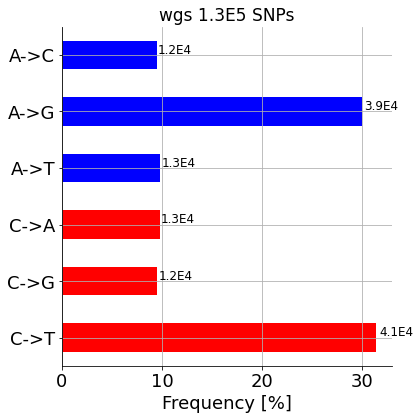

In [129]:
snps_statistics_annot(no_gt_statistics_unfiltered_wgs,no_gt_statistics_filtered_wgs,'wgs')


## Trinucleotide Heatmap
Heatmap for motif alterations in trinucleotide context

In [130]:
def plot_heatmap(motifs,ax=None, title_prefix = ""):
    
    if ax is None:
        plt.figure()
        ax = plt.gca()
    plt.sca(ax)

    plt.title(f"{title_prefix} Trinucleotide context", fontsize=20)
    
    x = (motifs / motifs.sum()).reset_index()
    x = x.assign(
        ref=x["ref_motif"].str.slice(1, 2),
        alt_motif=x["ref_motif"].str.slice(0, 1)
        + x["alt_1"]
        + x["ref_motif"].str.slice(2),
        left=x["ref_motif"].str.slice(0, 1),
        right=x["ref_motif"].str.slice(2),
    )
    x = x.assign(
        family=x.apply(
            lambda y: f"{y['ref']}->{y['alt_1']}",
            axis=1,
        )
    )
    
    table_str = "\n".join(
        (
            x["ref_motif"]
            + "->"
            + x["alt_motif"]
            + "  "
            + (x["size"]).apply(lambda x: f"{x:.1%}")
        )
        .loc[x.sort_values("size", ascending=False).head(12).index]
        .values
    )
    x = x.pivot_table(
        index=[
            "family",
            "left",
        ],
        columns=["right"],
        values="size",
    ).sort_index(ascending=False)
    
    ax.text(
        0.25,
        -0.15,
        table_str,
        transform=ax.transAxes,
        fontsize=16,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="#EEEEEE"),
    )

    bbox_extra_artists = list()
    data = np.concatenate((x.iloc[:12, :], x.iloc[12:, :]), axis=1) * 100
    plt.imshow(data, cmap="viridis")
    cbar = plt.colorbar()
    cbar.ax.get_yaxis().set_ticks(
        range(
            int(np.ceil(min(cbar.ax.get_yaxis().get_ticklocs()))),
            1 + int(max(cbar.ax.get_yaxis().get_ticklocs())),
            10 if (int(max(cbar.ax.get_yaxis().get_ticklocs()))-int(np.ceil(min(cbar.ax.get_yaxis().get_ticklocs())))>10) else 1))
    cbar.ax.set_ylabel("Frequency [%]", fontsize=24, rotation=270, labelpad=30)
    plt.xticks(range(8), list(x.columns) + list(x.columns))
    plt.yticks(range(12), x.iloc[:12, :].index.get_level_values("left"))
    plt.ylabel("Left base")
    plt.xlabel("Right base")
    plt.grid()
    xlim = plt.gca().get_xlim()
    ylim = plt.gca().get_ylim()
    plt.plot(np.ones(2) * (xlim[0] + (xlim[1] - xlim[0]) / 2), ylim, "-w", linewidth=2)
    plt.plot(xlim, np.ones(2) * (ylim[0] + (ylim[1] - ylim[0]) / 3), "-w", linewidth=2)
    plt.plot(
        xlim, np.ones(2) * (ylim[0] + (ylim[1] - ylim[0]) * 2 / 3), "-w", linewidth=2
    )

    X = np.repeat(
        [
            [
                (xlim[0] + (xlim[1] - xlim[0]) / 4),
                (xlim[0] + (xlim[1] - xlim[0]) * 3 / 4),
            ]
        ],
        3,
        axis=0,
    )
    Y = np.repeat(
        [
            [
                (ylim[0] + (ylim[1] - ylim[0]) * 5 / 6),
                (ylim[0] + (ylim[1] - ylim[0]) * 3 / 6),
                (ylim[0] + (ylim[1] - ylim[0]) / 6),
            ]
        ],
        2,
        axis=0,
    ).T
    T = np.vstack(
        (
            x.iloc[:12:4, :].index.get_level_values("family").values,
            x.iloc[12::4, :].index.get_level_values("family").values,
        )
    ).T

    for xx, yy, tt in zip(X.flatten(), Y.flatten(), T.flatten()):
        plt.text(xx, yy, tt, color="#BB5555", fontsize=28, ha="center", va="center")


In [137]:
def heatmap_annot(no_gt_statistics_unfiltered,no_gt_statistics_filtered):
    
    #for no_gt_statistics_unfiltered,no_gt_statistics_filtered,annotation_name in zip(no_gt_statistics_unfiltered_files,no_gt_statistics_filtered_files,annotation_intervals_names):   
    motifs = pd.read_hdf(no_gt_statistics_unfiltered,'snp_motifs')
    
    if no_gt_statistics_filtered != '':   
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 10))
        plot_heatmap(motifs, axes[0], 'wgs')
        filtered_motifs = pd.read_hdf(no_gt_statistics_filtered,'snp_motifs')
        plot_heatmap(filtered_motifs, axes[1], f"wgs Filter Pass")
    else:
        fig, ax = plt.subplots(figsize=(17, 10))
        plot_heatmap(motifs, ax, 'wgs')

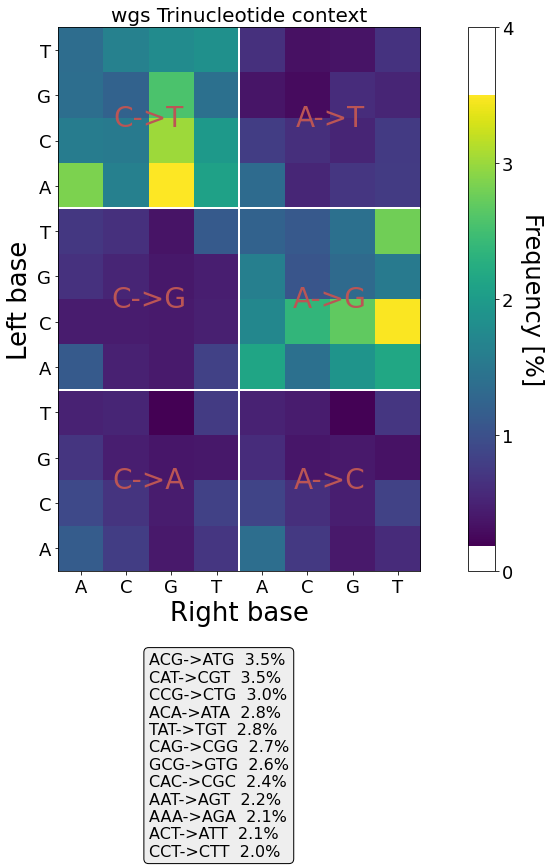

In [138]:
heatmap_annot(no_gt_statistics_unfiltered_wgs,no_gt_statistics_filtered_wgs)

# INDEL statistics

## Distribution of indel lengths

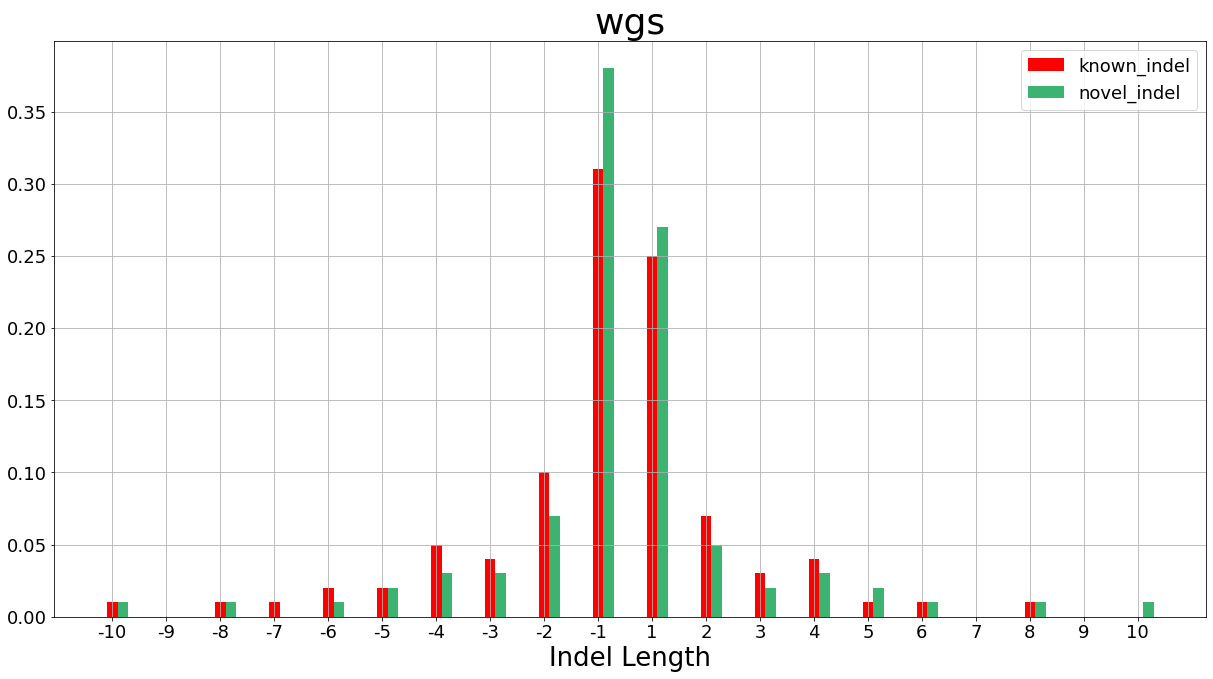

In [139]:
def ins_del_hete_graph_annot(known_indel,novel_indel,filtered_known_indel,filtered_novel_indel, title=None):
    add_filtered_data =  filtered_known_indel is not None
    X = np.arange(20)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    
    ax.bar(X + 0.00, known_indel, color = 'r', width = 0.20)
    ax.bar(X + 0.20, novel_indel, color = 'mediumseagreen', width = 0.20)
    if add_filtered_data:
        ax.bar(X + 0.40, filtered_known_indel, color = 'purple', width = 0.20)
        ax.bar(X + 0.60, filtered_novel_indel, color = 'g', width = 0.20)

    ax.set_title(title)
    ax.set_xticks(np.arange(0,20))
    ax.set_xticklabels([-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10])
    if add_filtered_data:
        ax.legend(labels=['known_indel', 'novel_indel', 'filtered_known_indel', 'filtered_novel_indel'])
    else:
        ax.legend(labels=['known_indel', 'novel_indel'])
    ax.set_xlabel('Indel Length')
    
    

def ins_del_hete_graph(no_gt_statistics_unfiltered,no_gt_statistics_filtered):
    
    #for no_gt_statistics_unfiltered,no_gt_statistics_filtered,annotation_name in zip(no_gt_statistics_unfiltered_files,no_gt_statistics_filtered_files,annotation_intervals_names):
        
    IndelLengthHistogram = pd.read_hdf(no_gt_statistics_unfiltered,'eval_IndelLengthHistogram')
    

    known_indel = IndelLengthHistogram[IndelLengthHistogram['Novelty']=='known']['Freq'].astype(float)
    novel_indel = IndelLengthHistogram[IndelLengthHistogram['Novelty']=='novel']['Freq'].astype(float)

    if no_gt_statistics_filtered != '':
        filtered_IndelLengthHistogram = pd.read_hdf(no_gt_statistics_filtered,'eval_IndelLengthHistogram')
        filtered_known_indel = filtered_IndelLengthHistogram[filtered_IndelLengthHistogram['Novelty']=='known']['Freq'].astype(float)
        filtered_novel_indel = filtered_IndelLengthHistogram[filtered_IndelLengthHistogram['Novelty']=='novel']['Freq'].astype(float)
    else:
        filtered_known_indel = None
        filtered_novel_indel = None

    ins_del_hete_graph_annot(known_indel,
               novel_indel,
               filtered_known_indel,
               filtered_novel_indel,
               title='wgs')
        
ins_del_hete_graph(no_gt_statistics_unfiltered_wgs,no_gt_statistics_filtered_wgs)

## Insertion Deletion Statistics for h-mer indels
Number of 1-base insretion deletions in hmer of each length

In [140]:
if not is_somatic:
    display(Markdown("""## Heterozygous
    """))

## Heterozygous
    

In [145]:
def ins_del_hete_graph(ins_del, ax, title):
    X = np.arange(12)
    
    ax.bar(X + 0.00, ins_del.iloc[0], color = 'r', width = 0.3)
    ax.bar(X + 0.3, ins_del.iloc[1], color = 'mediumseagreen', width = 0.3)
    ax.bar(X + 0.00, -ins_del.iloc[2], color = 'purple', width = 0.3)
    ax.bar(X + 0.3, -ins_del.iloc[3], color = 'g', width = 0.3)

    ax.set_title(title, fontsize=18)
    ax.set_xticks(np.arange(0,12))
    ax.set_xticklabels(pd.Series(np.arange(1,13)).apply(lambda x: f"hmer {x}"),rotation=45)
    ax.legend(labels=['ins A', 'ins G', 'del A', 'del G'])
    ax.set_yticks(ax.get_yticks())
    
    ax.set_yticklabels([abs(x).astype(int) for x in ax.get_yticks()])
    ax.set_ylabel("Deletion        /       Insertion",

               loc="center")

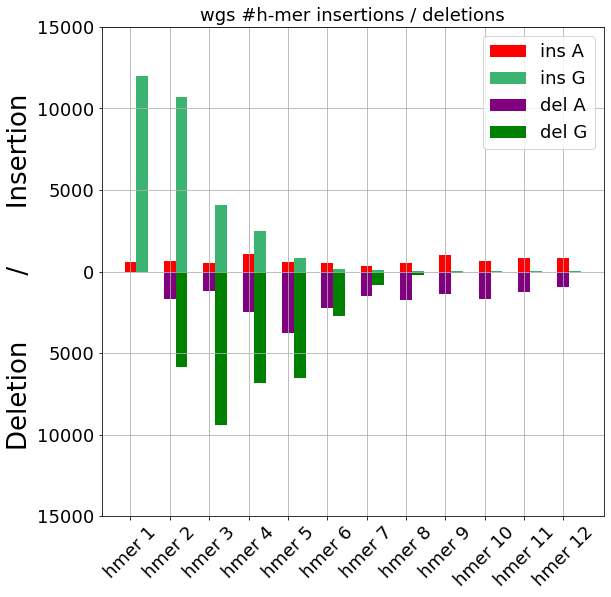

In [151]:
annotation_name = 'wgs'
ins_del_hete = pd.read_hdf(no_gt_statistics_unfiltered_wgs,'ins_del_hete')
ins_del_hete.columns = pd.Series(ins_del_hete.columns).apply(lambda x: f"h-mer {x}")

if no_gt_statistics_filtered_wgs !='':
    filtered_ins_del_hete = pd.read_hdf(no_gt_statistics_filtered_wgs,'ins_del_hete')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

    ins_del_hete_graph(ins_del_hete, axes[0], f'{annotation_name} #h-mer insertions / deletions')
    ins_del_hete_graph(filtered_ins_del_hete, axes[1], f'{annotation_name} #Filter Pass h-mer insertions / deletions')
else:
    fig, ax = plt.subplots(figsize=(9, 9))
    ins_del_hete_graph(ins_del_hete, ax, f'{annotation_name} #h-mer insertions / deletions')

In [152]:
if not is_somatic:
    display(Markdown("""## Homozygous
    """))

## Homozygous
    

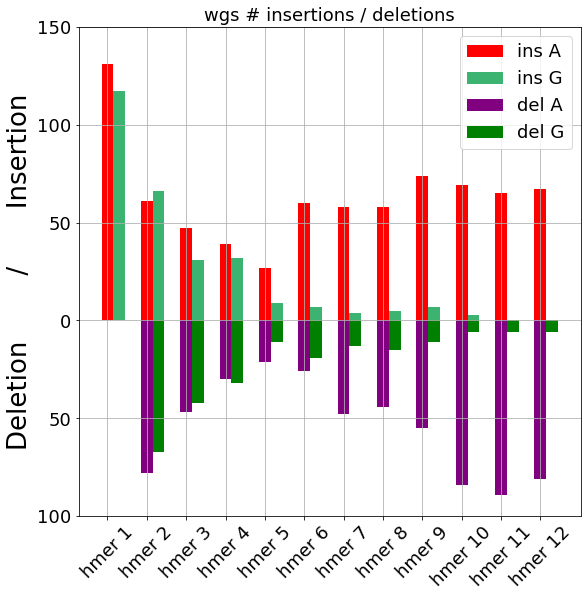

In [154]:
if not is_somatic:
    ins_del_homo = pd.read_hdf(no_gt_statistics_unfiltered_wgs,'ins_del_homo')
    ins_del_homo.columns = pd.Series(ins_del_homo.columns).apply(lambda x: f"h-mer {x}")
    if no_gt_statistics_filtered_wgs !='':
        filtered_ins_del_homo = pd.read_hdf(no_gt_statistics_filtered_wgs,'ins_del_homo')
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

        ins_del_hete_graph(ins_del_homo, axes[0], f'wgs # insertions / deletions')
        ins_del_hete_graph(filtered_ins_del_homo, axes[1], f'wgs #Filter Pass insertions / deletions')
    else:
        fig, ax = plt.subplots(figsize=(9, 9))
        ins_del_hete_graph(ins_del_homo, ax, f'wgs # insertions / deletions')